<div style="background-color:white">
  <div align="center">
    <img src="../../imgs/techfak_logo.jpg" width="400" height="250">
    <hr>
    <h1 style="color:black">Identify Trial Population for Clinical Studies on Diabetes<h1>
    <img src="https://www.mad.tf.fau.de/files/2019/04/logo_mad.png" width="230" height="150">
        <h2>Machine Learning Notebook</h2>
  </div>
  <hr>
</div>

### Background:

**Background of my project**: 

Due to the new upcoming new law from our german Minister of Health, there will appear infinite opportunities for what to do with all the data. The new law enforces a combined storage of all patient data into one so-called `elektronische Patientenakte (electrical patient file)`, in order the allow hospitals and doctors to look into the entire sickness history of the patient with the purpose of providing better healthcare accordingly. Nevertheless, security and data privacy plays a vital role. EHR data (electronic health records) become more and more a key source for clinical regulatories to make decisions on clinical trials. Furthermore most people learn machine learning or deep learning with mostly the same datasets (MNIST, CIFAR10, CIFAR100, etc..). The gathering of all this new upcoming data can be a unique opportunity to anonymize the data and provide it to the broad public for a testing and training purpose. We could replace the common practise datasets with real, revelant to society datasets and maybe achieve new state-of-art treatments for patients and save lifes. 
Of course for making this data publicly available, there needs to be a really high level of privacy and anonymization of the data. With my projects I am regarding that I received my dataset through this new data source and it is already anonymized. I show a possible use case of what to do with such data, namely predicting if people are applicable of participating for a clinical study on a new drug to potentially cure diabetes.


### Objective:
**Estimated Hospitalization Time with a Tensorflow Regression Model:** 

Using a synthetic dataset from the UCI Diabetes readmission dataset (https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008), I predict the expected days for a person to be hospitalized after certain conditions or treatments. This result can be used to decide whether or not a patient is going to be included into the clinical trial or not. This project shows the importance of splitting the data appropriately without data leakage and evaluating the results to make it transparent for the official use case, e.g. being accepted by the Arzneimittelbehörde as a tool.

### `Outline of the Notebook`

- [1. Import Packages](#1)
- [2. Load the Dataset](#2)
- [3. Preprocessing](#3)
    - [3.1 Select first encounter for preventing data leakage](#3.1)
    - [3.2 Aggregate dataset back into the right aggregation level for modelling](#3.2)
- [4. Feature Engineering](#4)
    - [4.1 Casting and Imputing](#4.1)
- [5. Modeling](#5)
    - [5.1 Train Test Split](#5.1)
    - [5.2 Demographic Representation Analysis of Split](#5.2)
    - [5.3 Demographic Group Analysis](#5.3)
    - [5.4 Convert Dataset Splits to TF Dataset](#5.4)
    - [5.5 Create Categorical Features with TF Feature Columns](#5.5)
    - [5.6 Create Categorical Features with Tensorflow Feature Column API](#5.6)
    - [5.7 Create Numerical Features with TF Feature Columns](#5.7)
- [6. Regression Model with Sequential API and TF Probability Layers](#6)
    - [6.1 Build Sequential API Model from DenseFeatures and TF Probability Layers](#6.1)
    - [6.2 Model Uncertainty with TF Probability](#6.2)
    - [6.3 Show Prediction Output](#6.3)
    - [6.4 Convert Regression Output to Classification Output for Patient Selection](#6.4)
- [7. Model Evaluation Metrics](#7)
    - [7.1 Missclassification](#7.1)
- [8. Evaluating Model Biases with Aequitas](#8)
    - [7.1 Prepare Data For Aequitas Bias Toolkit](#7.1)  
    - [7.2 Reference Group Selection](#7.2)
    - [7.3 Race and Gender Bias Analysis for Patient Selection](#7.3)
    - [7.4 Fairness Analysis Example - Relative to a Reference Group](#7.4)

<a name='1'></a>
# 1. Import Packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.optimizers import Adamax
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae
from sklearn.metrics import auc, f1_score, roc_auc_score, recall_score, precision_score, brier_score_loss
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer


import sys  
sys.path.insert(0, '../Scripts')

from model_preprocessing_utils import *
from tensorflow_modeling import *
from utils import check_null_values

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

<a name='2'></a>
# 2. Load the Dataset

In [3]:
df = pd.read_csv("../../data/final_preprocessed_df.csv").rename(columns={'race': 'ethnicity'})
print(f"Shape: {df.shape}")
df.head()

Shape: (143460, 25)


,encounter_id,patient_nbr,ethnicity,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,number_emergency,number_inpatient,primary_diagnosis_code,number_diagnoses,max_glu_serum,A1Cresult,change,readmitted,secondary_diagnosis_codes,drug_name
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,?,...,0,0,250.83,1,None,None,No,NO,?|?,NaN
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,?,...,0,0,276,9,None,None,Ch,>30,250.01|255,Troglitazone
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,?,...,0,1,648,6,None,None,No,NO,250|V27,Troglitazone
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,?,...,0,0,8,7,None,None,Ch,NO,250.43|403,Troglitazone
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,...,0,0,197,5,None,None,Ch,NO,157|250,Glipizide


<a name='3'></a>
# 3. Preprocessing

<a name='3.1'></a>
### 3.1 Select first encounter for preventing data leakage

In [4]:
line_level_df = select_first_encounter(df)
print(f"First encounter shape: {line_level_df.shape}")

First encounter shape: (71518, 25)


In [5]:
# unique patients in transformed dataset
unique_patients = line_level_df['patient_nbr'].nunique()
print("Number of unique patients: {}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = line_level_df['encounter_id'].nunique()
print("Number of unique encounters: {}".format(unique_encounters))

original_unique_patient_number = df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients: 71518
Number of unique encounters: 71518
Tests passed!!


<a name='3.2'></a>
### 3.2 Aggregate dataset back into the right aggregation level for modelling

In order to simplify the data aggregation for the model, I will only select the first encounter for each patient in the dataset ascending to the encounter_id. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. I assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [6]:
grouping_field_list = [col for col in line_level_df.columns if col not in ['drug_name']]
encounter_level_df, ndc_col_list = aggregate_dataset(line_level_df, grouping_field_list, 'drug_name')
print(f"Encounter level shape: {encounter_level_df.shape}")

../Scripts/model_preprocessing_utils.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(grouping_field_list)['encounter_id', array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={0: array_field + "_array"})


Encounter level shape: (71518, 44)


In [7]:
assert len(encounter_level_df) == encounter_level_df['patient_nbr'].nunique() == encounter_level_df['encounter_id'].nunique()

#### Features 

The payer_code has around 1/3rd of the dataset with no information, which is still good enough I guess to use. Furthermore payer_code has a decent level of kardinality, which is good.

In [8]:
print(f"Payer_code ? : {len(encounter_level_df[encounter_level_df.payer_code == '?'])}")
encounter_level_df.payer_code.unique()

Payer_code ? : 31043


array(['?', 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

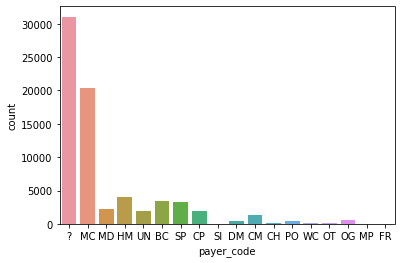

In [9]:
sns.countplot(encounter_level_df.payer_code)

<a name='4'></a>
# 4. Feature Engineering

In [10]:
encounter_level_df = encounter_level_df.dropna()

## split for the other diagnosis codes
col_cat_other_codes = encounter_level_df['secondary_diagnosis_codes'].str.split("|")
other_diagnosis_codes = ['sec_diagnosis_code_1', 'sec_diagnosis_code_2']

for codes, col in zip(col_cat_other_codes, other_diagnosis_codes):
    encounter_level_df[col] = codes[0]
    encounter_level_df[col] = codes[1]

In [11]:
encounter_level_df['drug_name_array'] = encounter_level_df['drug_name_array'].apply(lambda x: x[0])

In [12]:
encounter_level_df.columns

Index(['encounter_id', 'patient_nbr', 'ethnicity', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'primary_diagnosis_code', 'number_diagnoses', 'max_glu_serum',
       'A1Cresult', 'change', 'readmitted', 'secondary_diagnosis_codes',
       'drug_name_array', 'Acarbose', 'Acetohexamide', 'Chlorpropamide',
       'Glimepiride', 'Glipizide', 'Glipizide_Metformin', 'Glyburide',
       'Glyburide_Metformin', 'Insulin', 'Metformin',
       'Metformin_Rosiglitazone', 'Miglitol', 'Nateglinide', 'Pioglitazone',
       'Repaglinide', 'Rosiglitazone', 'Tolazamide', 'Tolbutamide',
       'Troglitazone', 'sec_diagnosis_code_1', 'sec_diagnosis_code_2'],
      dtype='object')

<a name='4.1'></a>
### 4.1 Feature Selection 

In [13]:
required_demo_col_list = ['ethnicity', 'gender', 'age']

categorical_col_list = ["readmitted", 'admission_type_id', 'discharge_disposition_id',
                        'max_glu_serum', 'admission_source_id', 'primary_diagnosis_code',
                        'change'] + required_demo_col_list + ndc_col_list + other_diagnosis_codes

numerical_col_list = ['number_diagnoses', 'num_medications', 'num_procedures']

PREDICTOR_FIELD = 'time_in_hospital'

In [14]:


selected_features_df = select_model_features(encounter_level_df, categorical_col_list, 
                                             numerical_col_list, PREDICTOR_FIELD)

In [15]:
assert len(set(selected_features_df.columns)) == selected_features_df.shape[1]

<a name='4.2'></a>
### 4.2 Casting and Imputing  

I will cast and impute the dataset before splitting so that I do not have to repeat these steps across the splits in the next step. For imputing I used the Simple Imputer from sklearn.impute

In [16]:
processed_df = preprocess_df(selected_features_df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD)

<a name='5'></a>
# 5. Modeling

<a name='5.1'></a>
### 5.1. Train Test Split

I will split the dataset into three partitions,  the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

- Approximately 60% - 20% - 20%  train/validation/test split
- Randomly sampled different patients into each data partition
- **IMPORTANT** A patient's data is not in more than one partition, so that there is no possible data leakage.
- The total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- The total number of rows in original dataset = sum of rows across all other partitions

In [17]:
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

Test passed for patient data in only one partition
Test passed for number of unique patients being equal!
Test passed for number of total rows equal!


In [18]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [19]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == selected_features_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


<a name='5.2'></a>
### 5.2 Demographic Representation Analysis of Split

It makes sense to check the distribution of the features, because we want the features balanced distributed across all val, train and test splits

**Original Dataset**

AxesSubplot(0.125,0.125;0.775x0.755)


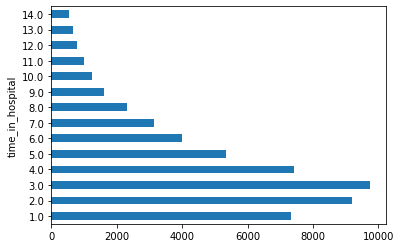

In [20]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

**Train Dataset**

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Train Dataset Split')

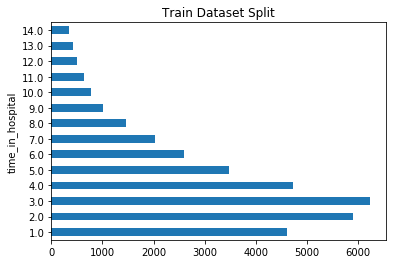

In [21]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)
plt.title("Train Dataset Split")

**Test Dataset**

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Test Dataset Split')

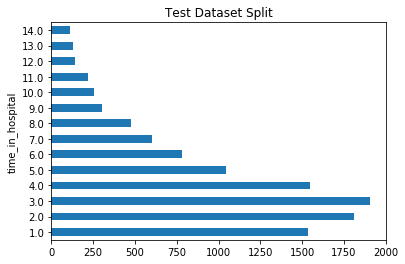

In [22]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)
plt.title("Test Dataset Split")

**Validation Dataset**

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Validation Dataset Split')

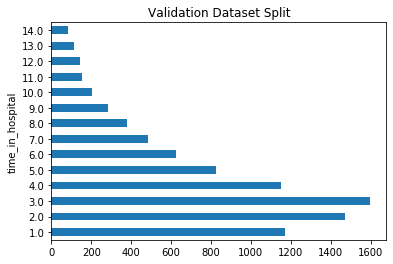

In [23]:
show_group_stats_viz(d_val, PREDICTOR_FIELD)
plt.title("Validation Dataset Split")

<a name='5.3'></a>
### 5.3 Demographic Group Analysis

It makes sense to not only check the balanced distribution of the labels, but also that the demography is equally distributed among all splits

**Original Dataset**

AxesSubplot(0.125,0.125;0.775x0.755)


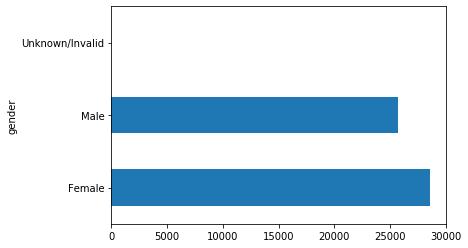

In [24]:
patient_demo_features = ['ethnicity', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

**Train Dataset**

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Train Dataset Split')

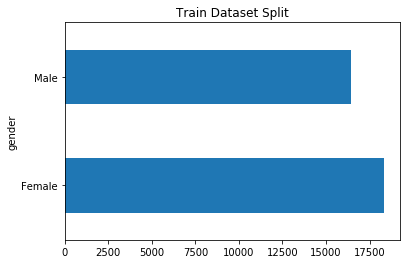

In [25]:
show_group_stats_viz(d_train, 'gender')
plt.title("Train Dataset Split")

**Test Dataset**

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Test Dataset Split')

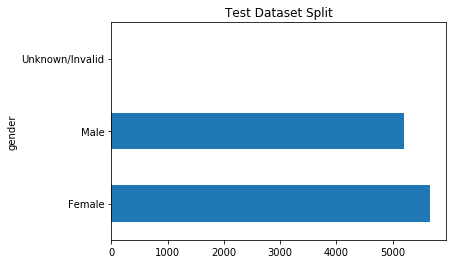

In [26]:
show_group_stats_viz(d_test, 'gender')
plt.title("Test Dataset Split")

**Validation Dataset**

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Validation Dataset Split')

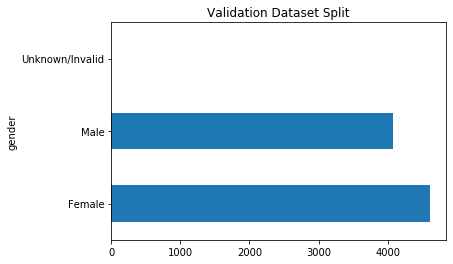

In [27]:
show_group_stats_viz(d_val, 'gender')
plt.title("Validation Dataset Split")

#### Evaluation on splitting

Looks good so far, everything is balanced splitted

<a name='5.4'></a>
### 5.4 Convert Dataset Splits to TF Dataset

In [28]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 32

diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

diabetes_batch = next(iter(diabetes_train_ds))[0]

<a name='5.5'></a>
### 5.5 Create Categorical Features with TF Feature Columns

In [29]:
high_kardinality_embedding = ['primary_diagnosis_code', 'sec_diagnosis_code_1', 'sec_diagnosis_code_2']
low_kardinality_indicator = np.setxor1d(categorical_col_list, high_kardinality_embedding)

vocab_file_list = build_vocab_files(d_train, categorical_col_list)

<a name='5.6'></a>
### 5.6 Create Categorical Features with Tensorflow Feature Column API

In [30]:
tf_cat_col_list = create_tf_categorical_feature_cols(high_kardinality_embedding, low_kardinality_indicator)

INFO:tensorflow:vocabulary_size = 610 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ../../data/diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 2 in sec_diagnosis_code_1 is inferred from the number of elements in the vocabulary_file ../../data/diabetes_vocab/sec_diagnosis_code_1_vocab.txt.
INFO:tensorflow:vocabulary_size = 2 in sec_diagnosis_code_2 is inferred from the number of elements in the vocabulary_file ../../data/diabetes_vocab/sec_diagnosis_code_2_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vocabulary_file ../../data/diabetes_vocab/Acarbose_vocab.txt.
INFO:tensorflow:vocabulary_size = 2 in Acetohexamide is inferred from the number of elements in the vocabulary_file ../../data/diabetes_vocab/Acetohexamide_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Chlorpropamide is inferred from the number of elements in the vocabulary_file ../../data

In [31]:
test_cat_var1 = tf_cat_col_list[20]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='Tolbutamide', vocabulary_file='../../data/diabetes_vocab/Tolbutamide_vocab.txt', vocabulary_size=3, num_oov_buckets=1, dtype=tf.string, default_value=-1))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)>

<a name='5.7'></a>
### 5.7 Create Numerical Features with TF Feature Columns

In [32]:
tf_num_col_list = create_tf_numerical_feature_cols(numerical_col_list, d_train)

In [33]:
test_num_var1 = tf_num_col_list[0]
print("Example continuous field:\n{}\n".format(test_num_var1))
demo(test_num_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_diagnoses', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7ffb56ec63b0>, mean=7.2695029340697275, std=2.003765024817031))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [-0.63355887]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [-0.63355887]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [-0.63355887]
 

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [-0.63355887],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [-0.63355887],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [-0.63355887],
       [-1.6316799 ],
       [-1.1326194 ],
       [-1.1326194 ],
       [ 0.8636226 ],
       [ 0.36456212],
       [ 0.8636226 ],
       [-0.63355887],
       [-2.6298008 ],
       [-1.1326194 ],
       [ 0.8636226 ],
       [ 0.36456212],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [ 0.8636226 ],
       [-1.1326194 ]], dtype=float32)>

<a name='6'></a>
# 6. Regression Model with Sequential API and TF Probability Layers

In [34]:
#claim_feature_columns = tf_cat_col_list + tf_num_col_list
claim_feature_columns = tf_num_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

In [35]:
demo(test_num_var1, diabetes_batch).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [-0.63355887]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [-0.63355887]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [-0.63355887]
 [-1.6316799 ]
 [-1.1326194 ]
 [-1.1326194 ]
 [ 0.8636226 ]
 [ 0.36456212]
 [ 0.8636226 ]
 [-0.63355887]
 [-2.6298008 ]
 [-1.1326194 ]
 [ 0.8636226 ]
 [ 0.36456212]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [ 0.8636226 ]
 [-1.1326194 ]], shape=(32, 1), 

TensorShape([32, 1])

<a name='6.1'></a>
### 6.1 Build Sequential API Model from DenseFeatures and TF Probability Layers

Fragen wegen metrics und val datensatz

In [36]:
import keras.backend as K

In [37]:
HUBER_DELTA = 0.5

def smoothL1(y_true, y_pred):
    x = K.abs(y_true - y_pred)
    if K._BACKEND == 'tensorflow':
        import tensorflow as tf
        x = tf.where(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
        return  K.sum(x)

In [38]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(2048, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable), 
        
        # Aleatoric Uncertainty           
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])),
    )])
    return model

def build_sequential_model2(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(164, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable), 
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])),
    )])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse', batch_size=32):
    model = build_sequential_model2(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=negloglik, metrics=loss_metric)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=15)     
    history = model.fit(train_ds, 
                        validation_data=val_ds, 
                        batch_size=batch_size,
                         #callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

# Versuchen

- smooth L1 Loss
- L1 Normal Loss
- Leaky RELU -> output Layer: passt output zum label?
- Lineare Aktivierung im letzten Layer

In [725]:
EPOCHS = 50

diabetes_model, history = build_diabetes_model(diabetes_train_ds, 
                                               diabetes_val_ds,  
                                               claim_feature_layer,  
                                               epochs=EPOCHS,
                                               batch_size=32,
                                               loss_metric='mse')

Epoch 1/50
1087/1087 [==============================] - 4s 3ms/step - loss: 18.7072 - mse: 20.3717 - val_loss: 10.2613 - val_mse: 14.8899
Epoch 2/50
1087/1087 [==============================] - 4s 3ms/step - loss: 8.4993 - mse: 12.8330 - val_loss: 7.1815 - val_mse: 13.2529
Epoch 3/50
1087/1087 [==============================] - 3s 3ms/step - loss: 6.6221 - mse: 12.4334 - val_loss: 6.3569 - val_mse: 12.9223
Epoch 4/50
1087/1087 [==============================] - 3s 3ms/step - loss: 5.7078 - mse: 12.3596 - val_loss: 5.6415 - val_mse: 13.2695
Epoch 5/50
1087/1087 [==============================] - 4s 3ms/step - loss: 5.1496 - mse: 13.4205 - val_loss: 4.7834 - val_mse: 13.8236
Epoch 6/50
1087/1087 [==============================] - 4s 3ms/step - loss: 4.7899 - mse: 14.2603 - val_loss: 4.5418 - val_mse: 13.5396
Epoch 7/50
1087/1087 [==============================] - 4s 3ms/step - loss: 4.4439 - mse: 15.5214 - val_loss: 4.3153 - val_mse: 15.4340
Epoch 8/50
1087/1087 [========================

In [284]:
# New Loss
loss, mse = diabetes_model.evaluate(diabetes_test_ds, verbose=2)

print(f"Loss: {loss}")
print(f"MSE: {mse}")

340/340 - 1s - loss: 3.9758 - mse: 21.4223
Loss: 3.9758238792419434
MSE: 21.422325134277344


# New Loss
loss, mse, cos = diabetes_model.evaluate(diabetes_test_ds, verbose=2)

print(f"Loss: {loss}")
print(f"MSE: {mse}")

<a name='6.2'></a>

### 6.2 Model Uncertainty with TF Probability

In [285]:
feature_list = categorical_col_list + numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [286]:
diabetes_yhat

<tfp.distributions.Normal 'sequential_12_distribution_lambda_12_Normal' batch_shape=[10864, 1] event_shape=[] dtype=float32>

In [287]:
m, s = get_mean_std_from_preds(diabetes_yhat)

In [288]:
diabetes_yhat.stddev()

<tf.Tensor: shape=(10864, 1), dtype=float32, numpy=
array([[2.7621636],
       [2.2457118],
       [2.056854 ],
       ...,
       [1.6936237],
       [1.4000726],
       [1.4583195]], dtype=float32)>

<a name='6.3'></a>
### 6.3 Show Prediction Output 

In [672]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": np.floor(m.numpy()).flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,7.894600,11.0,8.0,2.762164
1,4.641302,7.0,6.0,2.245712
2,9.253166,6.0,5.0,2.056854
3,3.323386,5.0,6.0,2.136048
4,8.365792,2.0,4.0,1.566655


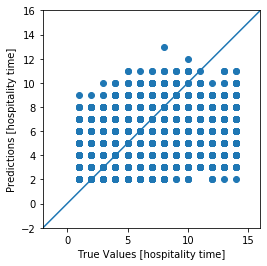

In [673]:
test_labels = prob_output_df['actual_value']
test_predictions = prob_output_df['pred_mean']

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions.astype(int))
plt.xlabel('True Values [hospitality time]')
plt.ylabel('Predictions [hospitality time]')
lims = [-2, 16]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

<a name='6.4'></a>
### 6.4 Convert Regression Output to Classification Output for Patient Selection

In [692]:
real_boundary = 5
days = 5

binary_prediction = get_binary_prediction(prob_output_df, 'pred_mean', days=real_boundary)

pred_test_df = add_pred_to_test(d_test, binary_prediction, ['ethnicity', 'gender'], days=days)
pred_test_df[['patient_nbr', 'gender', 'ethnicity', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,ethnicity,time_in_hospital,score,label_value
45016,24187770,Female,AfricanAmerican,11.0,1,1
70382,110774223,Female,Caucasian,7.0,1,1
7306,921879,Male,Caucasian,6.0,1,1
22738,12720501,Female,?,5.0,1,1
66909,107313192,Female,Caucasian,2.0,0,0


### Compare

In [693]:
days = 1

pred_test_df_test = add_pred_to_test(d_test, binary_prediction, ['ethnicity', 'gender'], days=days)
pred_test_df_test[['patient_nbr', 'gender', 'ethnicity', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,ethnicity,time_in_hospital,score,label_value
45016,24187770,Female,AfricanAmerican,11.0,1,1
70382,110774223,Female,Caucasian,7.0,1,1
7306,921879,Male,Caucasian,6.0,1,1
22738,12720501,Female,?,5.0,1,1
66909,107313192,Female,Caucasian,2.0,0,1


<a name='7'></a>
# 7. Model Evaluation Metrics 

- Precison score measure the accuracy for truely identified true values
- Recall score measure the accuracy for truely identified false values

To us it is **way more important** to find patients who truely satisfy the criteria to be tested for the new drug and we really don't wanna falsely identify someone who is not appropriate. For that reason, we rather omit some people who would be able, but take that into account to enhance our False Negative Rate (FNR).

In my specific case, I don't really know how it can be that precision and recall is almost equal, but still my model performed poorly anyways. 

So we urgently want a FPR as low as possible

In [694]:
print_metric_scores(pred_test_df);

Brier score : 0.3068851251840943
AUC score :  0.6808461061717447
F1 score :  0.6953785528592442
Precision score:  0.6931148748159057
Recall score :  0.6931148748159057


In [695]:
print_metric_scores(pred_test_df_test);

Brier score : 0.5942562592047128
AUC score :  0
F1 score :  0.5772655840754322
Precision score:  0.4057437407952872
Recall score :  0.4057437407952872


In [696]:
briers = []
aucs = []
f1s = []
pres = []
recs = []

for i in range(1, 23):
    pred_test_df = add_pred_to_test(d_test, binary_prediction, ['ethnicity', 'gender'], days=i)
    bs, auc, f1, pre, rec = print_metric_scores(pred_test_df, print_results=False)
    
    briers.append(bs)
    aucs.append(auc)
    f1s.append(f1)
    pres.append(pre)
    recs.append(rec)

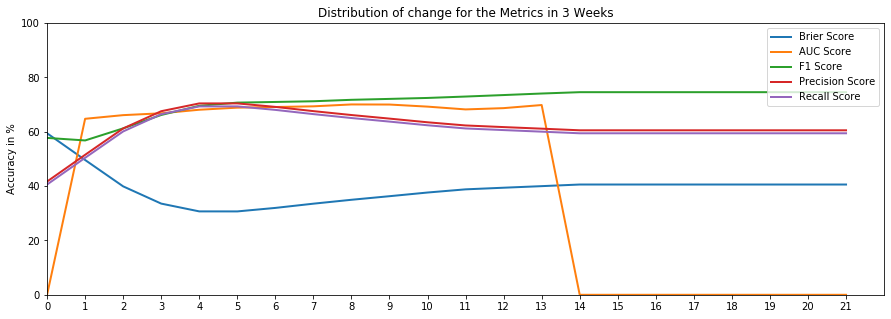

In [697]:
plt.figure(figsize=(15,5))
plt.plot(np.array(briers)*100, label="Brier Score", linewidth=2.0)
plt.plot(np.array(aucs)*100, label="AUC Score", linewidth=2.0)
plt.plot(np.array(f1s)*100, label="F1 Score", linewidth=2.0)
plt.plot(np.array(pres)*100 + 1.1, label="Precision Score", linewidth=2.0, alpha=1)
plt.plot(np.array(recs)*100, label="Recall Score", linewidth=2.0)
plt.xticks(np.arange(-3,22))
plt.ylim((0,100))
plt.xlim((0,22))
plt.legend(loc='upper right')
plt.ylabel('Accuracy in %')
plt.title('Distribution of change for the Metrics in 3 Weeks')
plt.show()

<a name='7.1'></a>
### 7.1 Missclassification Referenz

In [698]:
def miss_classify(pred_df):
    cols = list(pred_df.columns) + list(prob_output_df.columns)
    temp_df = pd.DataFrame(np.hstack((pred_df, prob_output_df)))
    temp_df.columns = cols

    missclassified_df = temp_df[temp_df['score'] != temp_df['label_value']].copy()
    missclassified_df['pred_mean'].plot(kind='hist')
    plt.show()

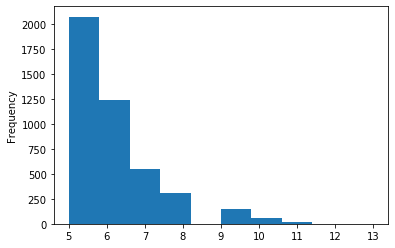

In [699]:
miss_classify(pred_test_df)

### 7.2 Missclassification Compare

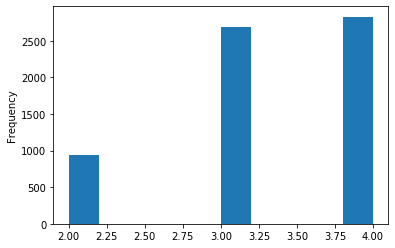

In [700]:
miss_classify(pred_test_df_test)

<a name='8'></a>
# 8. Evaluating Model Biases with Aequitas

<a name='8.1'></a>
### 8.1 Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields

In [701]:
set(pred_test_df['ethnicity'])

{'?', 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other'}

In [702]:
pred_test_df = pred_test_df.rename(columns={'race': 'ethnicity'}).copy()
#pred_test_df_test = pred_test_df_test.rename(columns={'race': 'ethnicity'}).copy()

In [703]:
import aequitas
fig = plt.figure(figsize=(15,5))

<Figure size 1080x360 with 0 Axes>

In [705]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

### REFERENCE
ae_subset_df = pred_test_df[['ethnicity', 'gender', 'score', 'label_value', 'age']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'ethnicity':'Caucasian', 'gender':'Male', 'age': '[40-50)'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

model_id, score_thresholds 1 {'rank_abs': [4408]}
get_disparity_predefined_group()


In [706]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

### TEST
ae_subset_df_test = pred_test_df_test[['ethnicity', 'gender', 'score', 'label_value', 'age']]
ae_df_test, _ = preprocess_input_df(ae_subset_df_test)
g_test = Group()
xtab_test, _ = g.get_crosstabs(ae_df_test)
absolute_metrics = g_test.list_absolute_metrics(xtab_test)
clean_xtab_test = xtab_test.fillna(-1)
aqp_test = Plot()
b_test = Bias()

# test reference group with Caucasian Male
bdf_test = b_test.get_disparity_predefined_groups(clean_xtab_test, 
                    original_df=ae_df_test, 
                    ref_groups_dict={'ethnicity':'Caucasian', 'gender':'Male', 'age': '[40-50)'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)

f_test = Fairness()
fdf_test = f_test.get_group_value_fairness(bdf_test)

model_id, score_thresholds 1 {'rank_abs': [4408]}
get_disparity_predefined_group()


<a name='8.2'></a>
### 8.2 Reference Group Selection

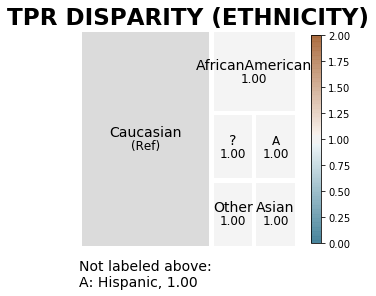

In [707]:
# 5 days
tpr_disparity_fairness = aqp.plot_disparity(fdf, 
                                                     group_metric='tpr', 
                                                     attribute_name='ethnicity', 
                                                     fig=fig);

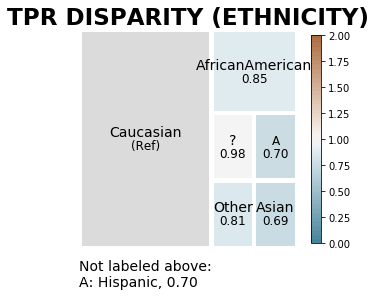

In [708]:
# One Week
tpr_disparity_fairness = aqp_test.plot_disparity(fdf_test, 
                                                     group_metric='tpr', 
                                                     attribute_name='ethnicity', 
                                                     fig=fig);

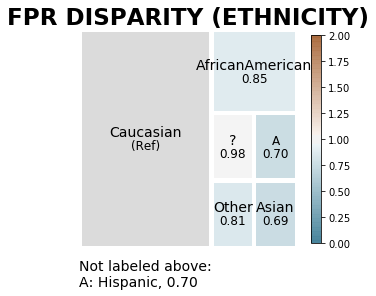

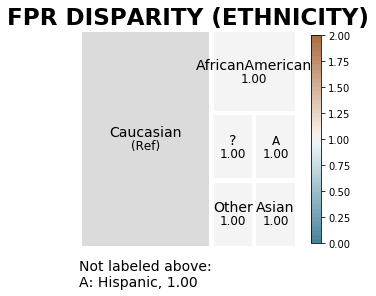

In [709]:
# 5 days
tpr_disparity_fairness = aqp.plot_disparity(fdf, 
                                                     group_metric='fpr', 
                                                     attribute_name='ethnicity', 
                                                     fig=fig);

# One Week
tpr_disparity_fairness = aqp.plot_disparity(fdf_test, 
                                                     group_metric='fpr', 
                                                     attribute_name='ethnicity', 
                                                     fig=fig);

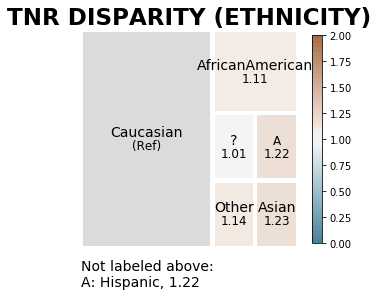

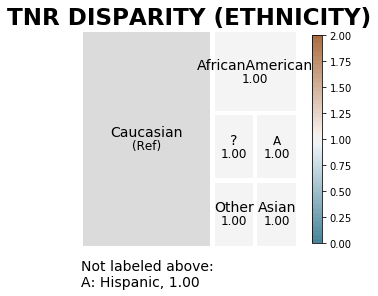

In [710]:
# 5 days
tpr_disparity_fairness = aqp.plot_disparity(fdf, 
                                                     group_metric='tnr', 
                                                     attribute_name='ethnicity', 
                                                     fig=fig);

# One Week
tpr_disparity_fairness = aqp.plot_disparity(fdf_test, 
                                                     group_metric='tnr', 
                                                     attribute_name='ethnicity', 
                                                     fig=fig);

<a name='8.3'></a>
### 8.3 Race and Gender Bias Analysis for Patient Selection

As said earlier, for me is the most important thing to be absolutely sure to not take people into the test which are actually wrongly chosen. So we want a as good as possible FPR.

We can see, that 4/5 times approximately people will get chosen incorrectly as being chosen for the clinical trial, even though they were actually not good for it, which is critical.
We especially see that Caucasians are most likely to be falsely identified, even though most of our data was caucasians. This leads to the conclusion, that our Regression model is actually really bad.

Unfortunately I don't know how to further improve it.

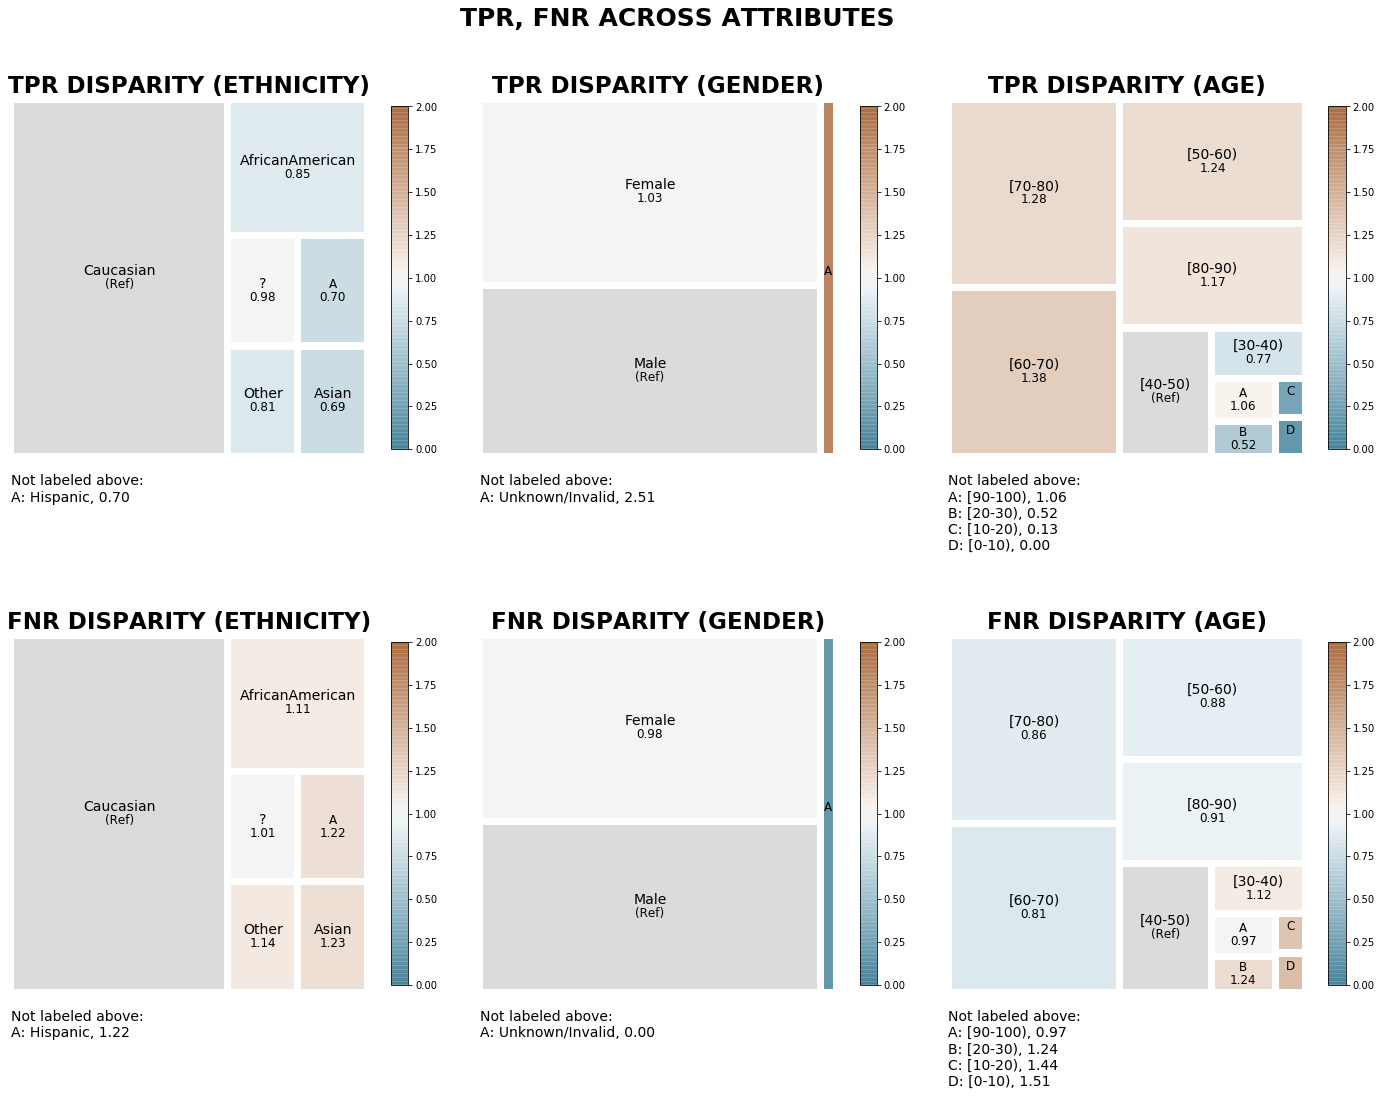

In [711]:
aqp.plot_disparity_all(bdf_test, metrics=['tpr', 'fnr']);

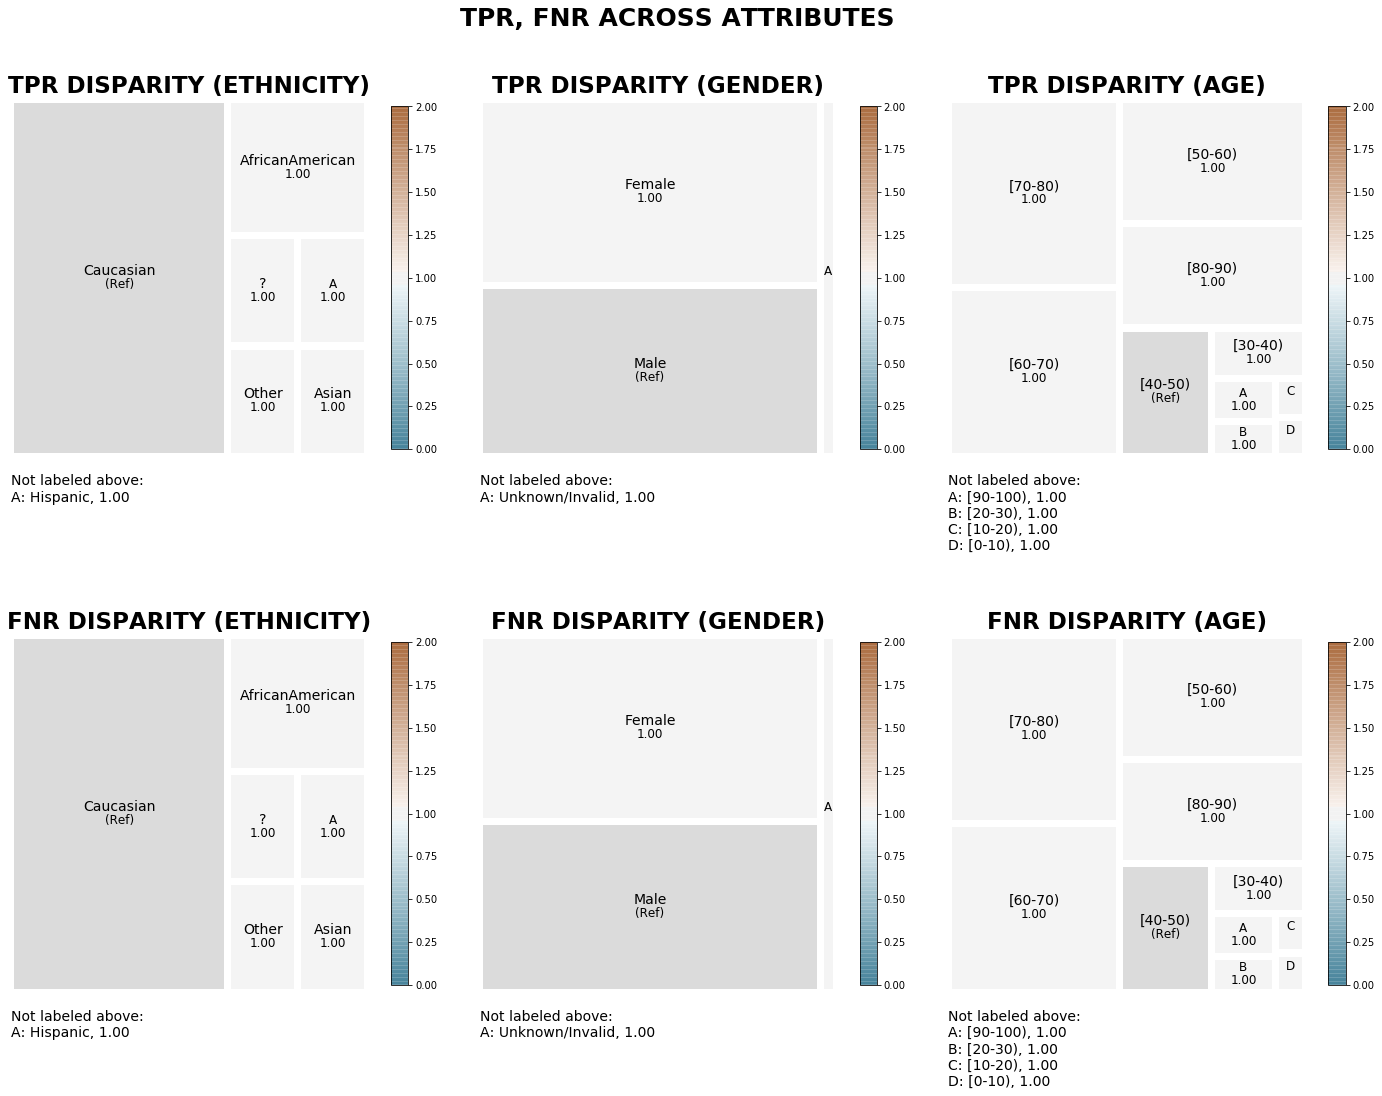

In [712]:
aqp.plot_disparity_all(bdf, metrics=['tpr', 'fnr']);

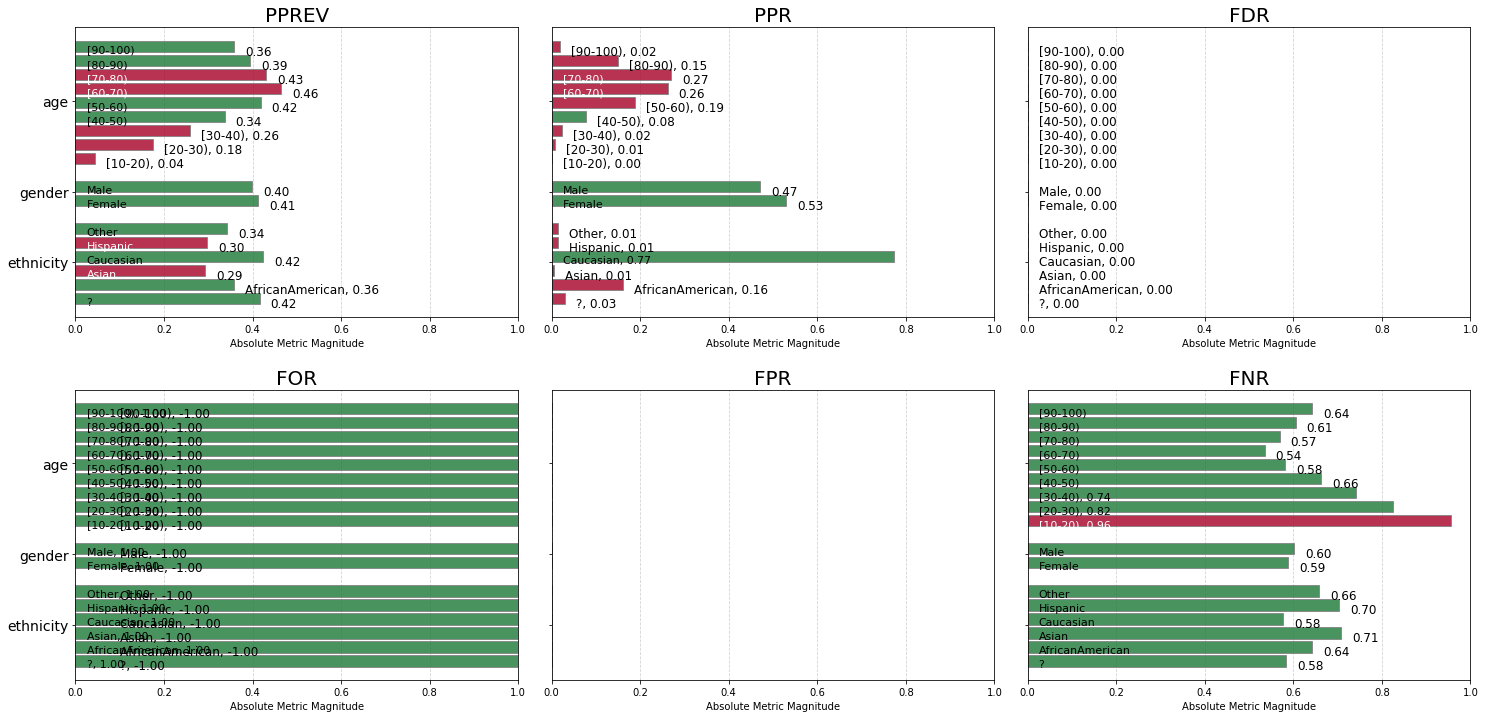

In [713]:
aqp.plot_fairness_group_all(fdf_test, min_group_size=0.001);

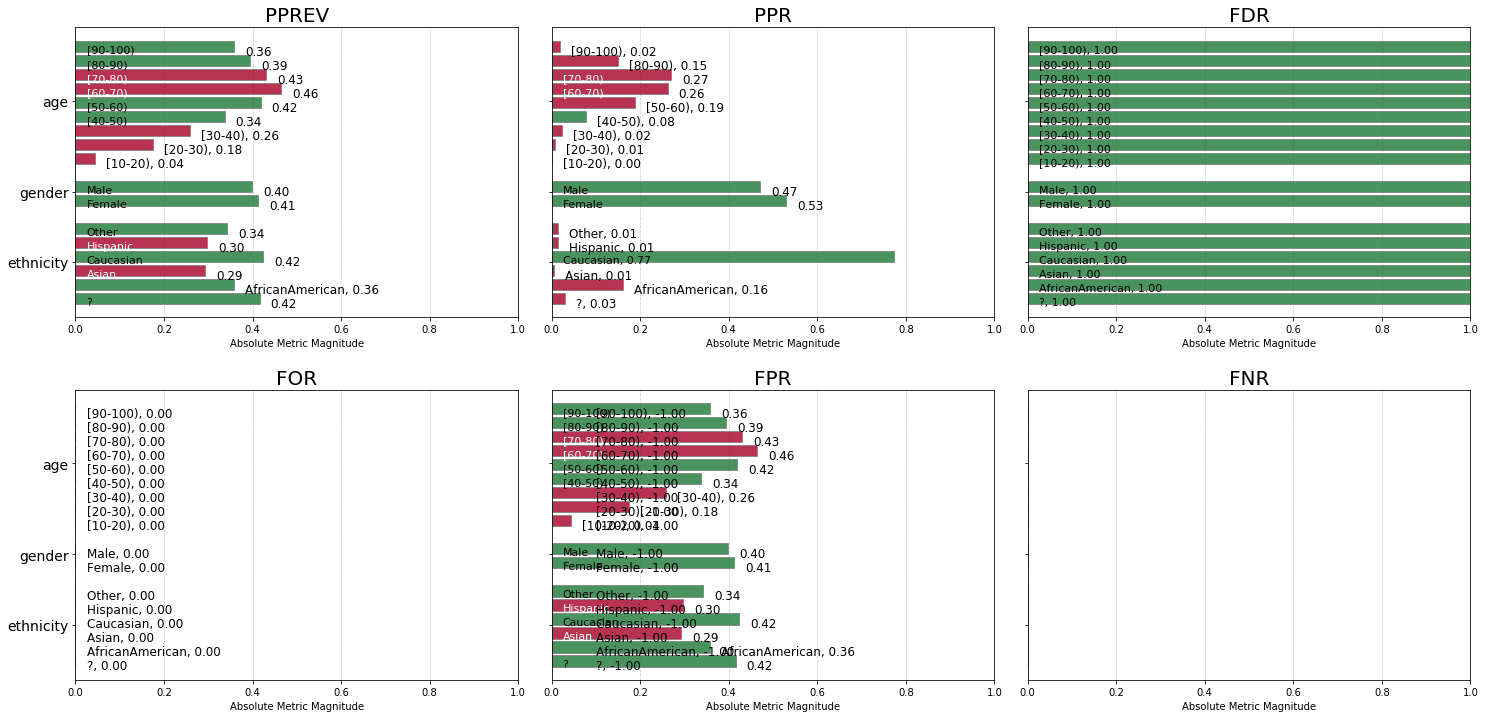

In [714]:
aqp.plot_fairness_group_all(fdf, min_group_size=0.001);

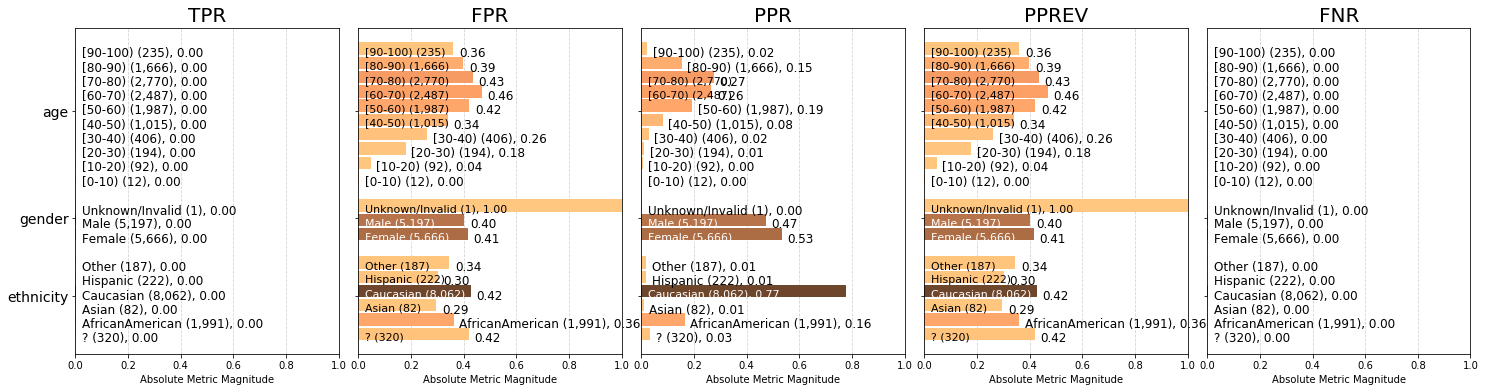

In [715]:
aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5);

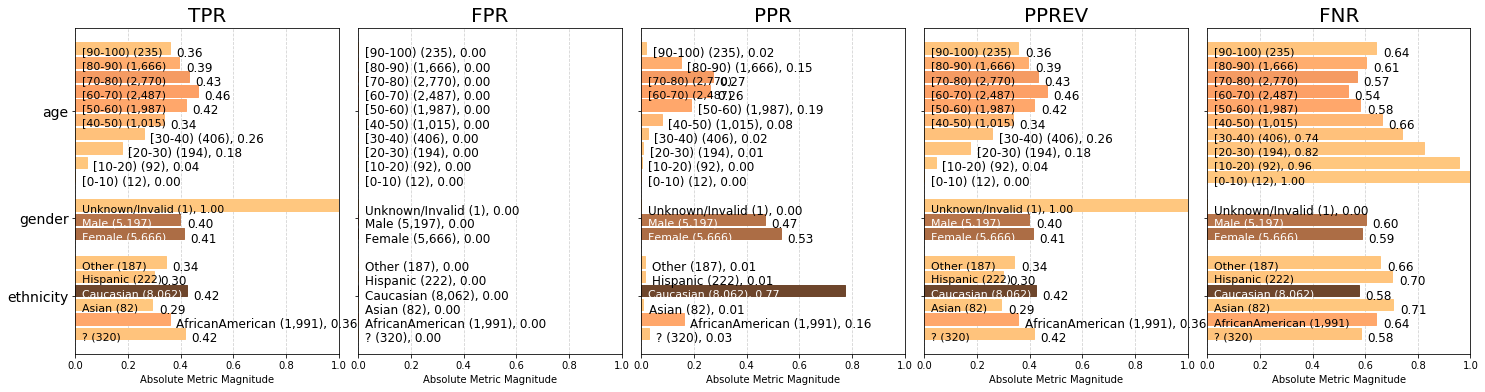

In [716]:
aqp.plot_group_metric_all(xtab_test, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5);

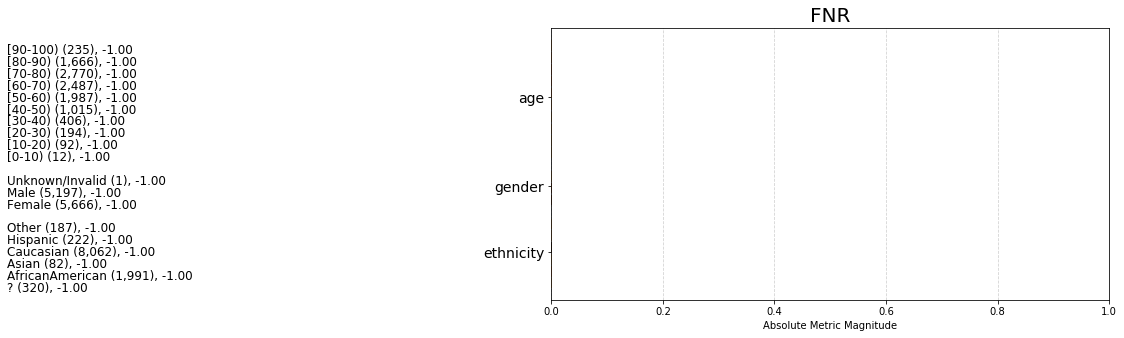

In [717]:
fpr = aqp.plot_group_metric(clean_xtab, 'fnr')

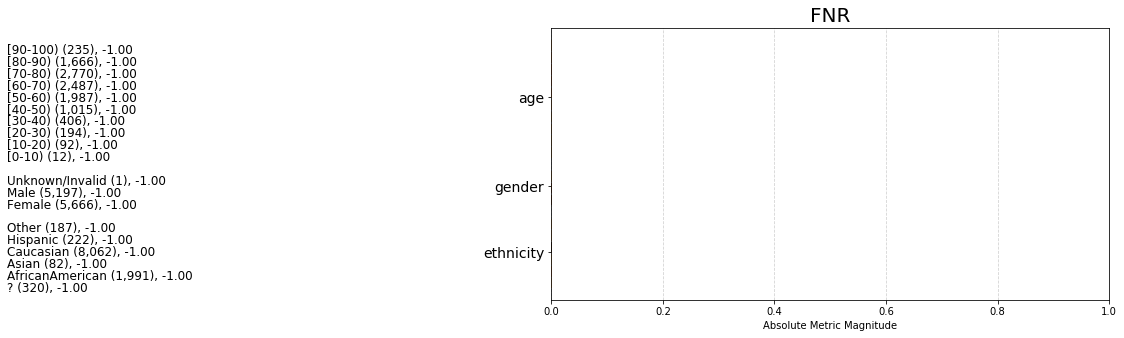

In [718]:
fpr = aqp.plot_group_metric(clean_xtab, 'fnr')

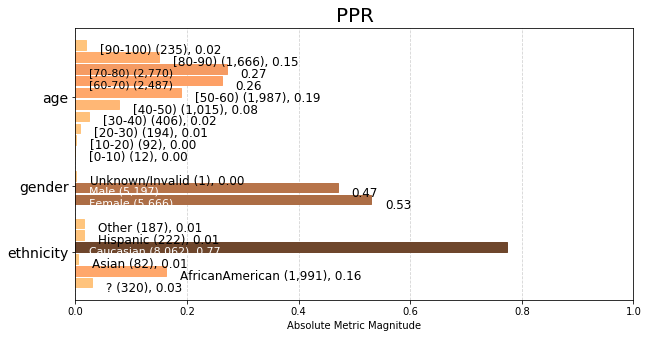

In [719]:
precision = aqp.plot_group_metric(clean_xtab, 'ppr');

<a name='8.4'></a>
### 8.4 Fairness Analysis Example - Relative to a Reference Group 

This reflects exactly what we saw earlier, that the more training data we had of a race, the worse the algorithm got.

### Ethnicity

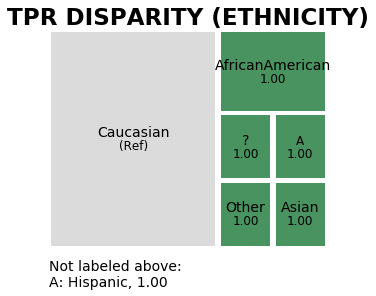

In [720]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, 
                                                     group_metric='tpr', 
                                                     attribute_name='ethnicity', 
                                                     fig=fig);

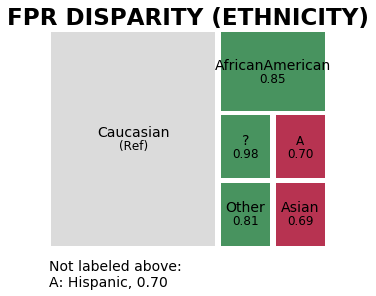

In [721]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='ethnicity')

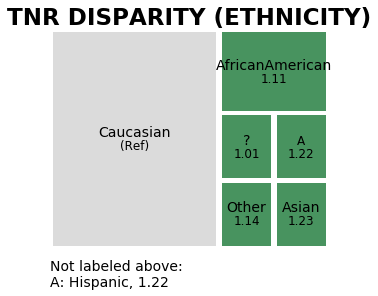

In [722]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tnr', attribute_name='ethnicity');

In [2]:
import numpy as np

In [12]:
np.log(1)

0.0

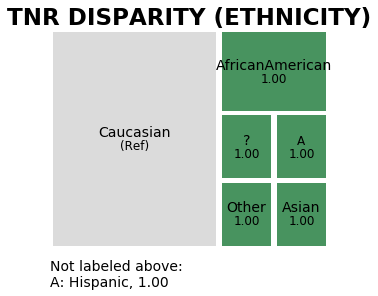

In [723]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf_test, group_metric='tnr', attribute_name='ethnicity');

### Gender

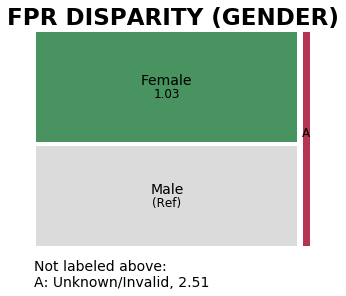

In [724]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='gender');

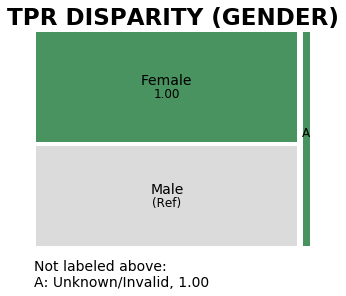

In [436]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='gender')

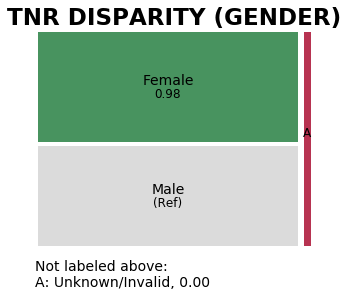

In [437]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tnr', attribute_name='gender')

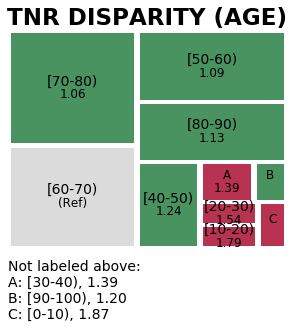

In [438]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tnr', attribute_name='age')

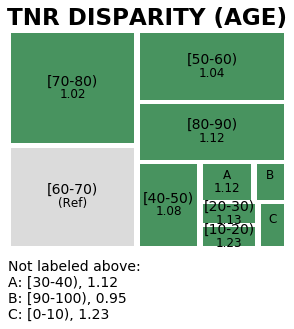

In [439]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf_test, group_metric='tnr', attribute_name='age')

<a name='8.5'></a>
### 8.5 Absolute Value Fairness Determination
- Red = False/Not Fair
- Green = True/Fair

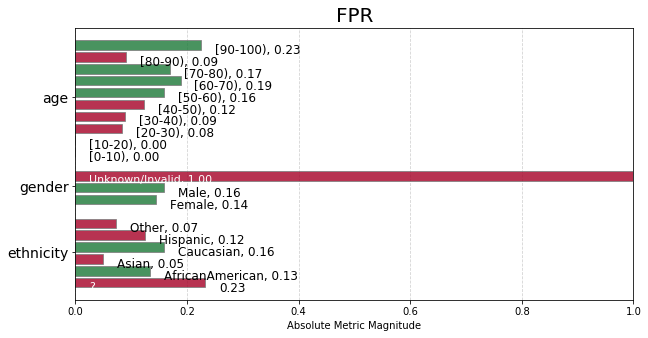

In [440]:
fpr_fairness = aqp.plot_fairness_group(fdf_test, group_metric='fpr', title=True)

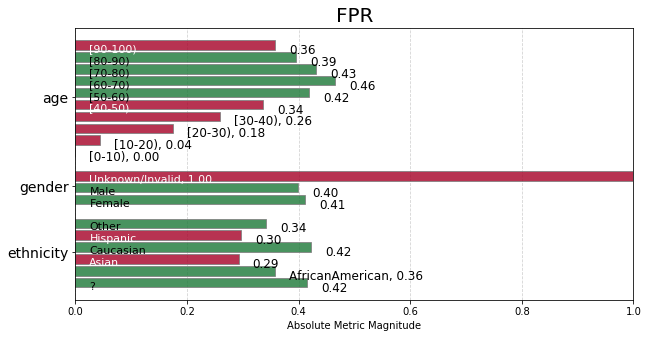

In [441]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

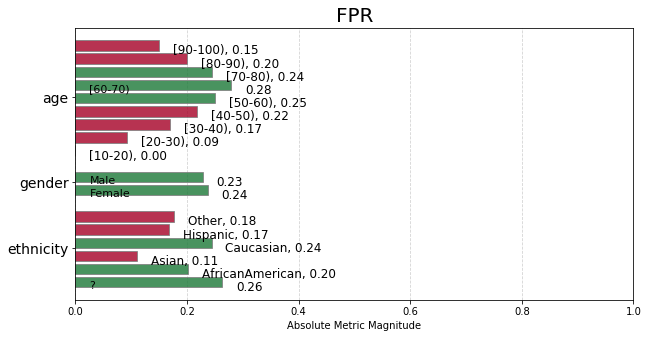

In [395]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True, min_group_size=0.001)

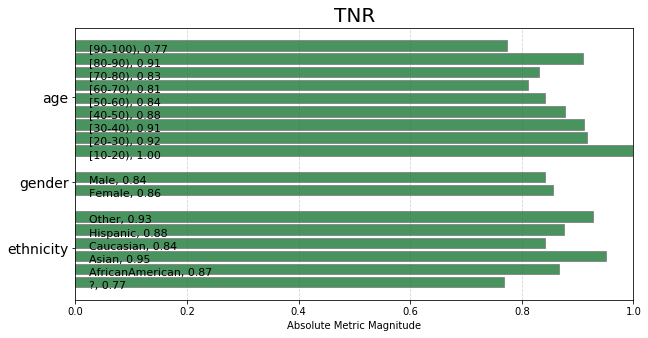

In [443]:
fpr_fairness = aqp.plot_fairness_group(fdf_test, group_metric='tnr', title=True, min_group_size=0.001)